Initialize everything

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Locate the dataset

In [4]:
data_dir = "data"
data_dir = pathlib.Path(data_dir)

Check if everything is working

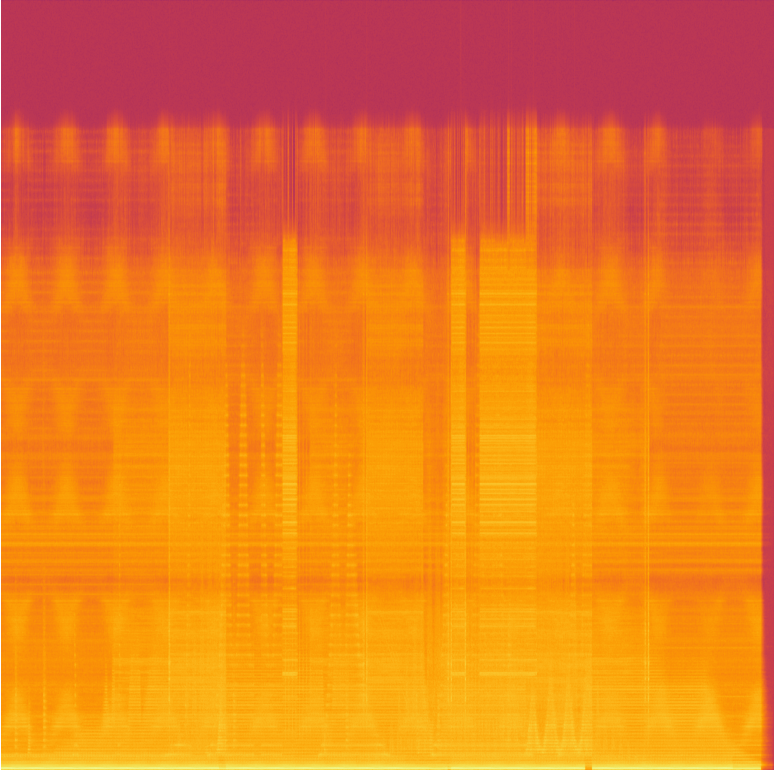

In [10]:
tracks = list(data_dir.glob("techno/*"))
PIL.Image.open(str(tracks[40]))

Define the dataset

In [12]:
batch_size = 32
img_height = 180
img_width = 180

Split dataset into training and validation

In [13]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 211 files belonging to 2 classes.
Using 169 files for training.


In [14]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 211 files belonging to 2 classes.
Using 42 files for validation.


Print class names

In [15]:
class_names = train_ds.class_names
print(class_names)

['house', 'techno']


Visualize data

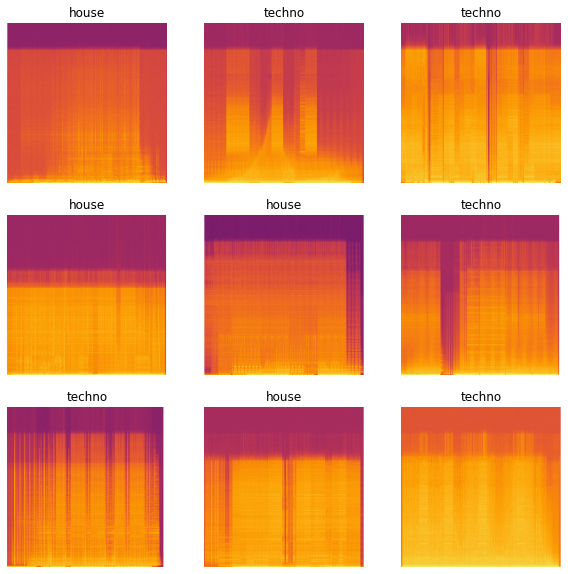

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Configure dataset performance

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Scale RGB values

In [19]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Create the model

In [20]:
num_classes = 2 #number of genres in the dataset
 
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile the model

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model summary

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

Train the model

In [23]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
6/6 [==============================] - 6s 1s/step - loss: 1.4154 - accuracy: 0.5207 - val_loss: 0.5164 - val_accuracy: 0.8095
Epoch 2/10
6/6 [==============================] - 4s 701ms/step - loss: 0.6489 - accuracy: 0.6627 - val_loss: 0.6437 - val_accuracy: 0.8095
Epoch 3/10
6/6 [==============================] - 4s 710ms/step - loss: 0.6570 - accuracy: 0.6627 - val_loss: 0.6044 - val_accuracy: 0.8095
Epoch 4/10
6/6 [==============================] - 4s 701ms/step - loss: 0.6452 - accuracy: 0.6686 - val_loss: 0.5463 - val_accuracy: 0.8095
Epoch 5/10
6/6 [==============================] - 4s 703ms/step - loss: 0.6391 - accuracy: 0.6686 - val_loss: 0.5755 - val_accuracy: 0.8095
Epoch 6/10
6/6 [==============================] - 4s 702ms/step - loss: 0.6315 - accuracy: 0.6686 - val_loss: 0.5478 - val_accuracy: 0.8095
Epoch 7/10
6/6 [==============================] - 4s 708ms/step - loss: 0.6229 - accuracy: 0.6746 - val_loss: 0.5519 - val_accuracy: 0.8095
Epoch 8/10
6/6 [=======

Evaluate the model

In [25]:
model.evaluate(train_ds, steps = 10)

 6/10 [=================>............] - 1s 217ms/step - loss: 0.6033 - accuracy: 0.7160


[0.603274941444397, 0.715976357460022]

Visualize the results

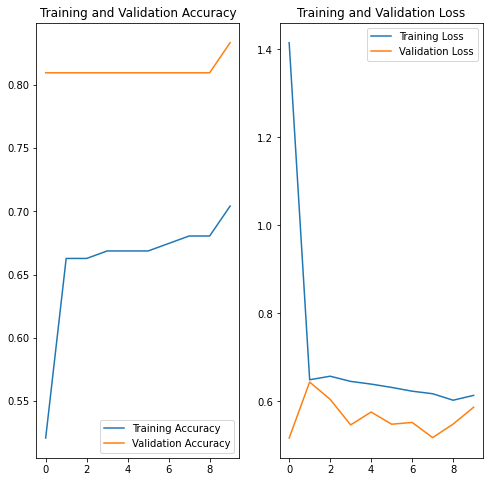

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Test on data not included in the dataset

In [39]:
track_path = "82NUfPBHxYs.png"

img = keras.preprocessing.image.load_img(track_path, target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to techno with a 50.49 percent confidence.
